<a href="https://colab.research.google.com/github/kiakass/recommendation/blob/main/Factorization_machine_srendle_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

blog : https://greeksharifa.github.io/machine_learning/2019/12/21/FM/ <br>
paper : https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf <br>
code :  <br>
1. 
https://colab.research.google.com/drive/1LVEjmdMfLntwqCq5tNYmEaYpOkWb1te0?usp=sharing <br>
2.
https://github.com/yoonkt200/recommender-system/tree/master/deprecated/factorization-machine


In [ ]:
# FM
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# GPU 확인
tf.config.list_physical_devices('GPU')

# 자료형 선언
tf.keras.backend.set_floatx('float32')

# 데이터 로드
scaler = MinMaxScaler()
file = load_breast_cancer()
X, Y = file['data'], file['target']
X = scaler.fit_transform(X)

n = X.shape[0]
p = X.shape[1]
k = 10
batch_size = 8
epochs = 10

In [ ]:
pd.DataFrame(file.data,columns=file.feature_names)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
class FM(tf.keras.Model):
    def __init__(self):
        super(FM, self).__init__()

        # 모델의 파라미터 정의
        self.w_0 = tf.Variable([0.0])
        self.w = tf.Variable(tf.zeros([p]))
        self.V = tf.Variable(tf.random.normal(shape=(p, k)))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = tf.math.sigmoid(self.w_0 + linear_terms + interactions)

        return y_hat

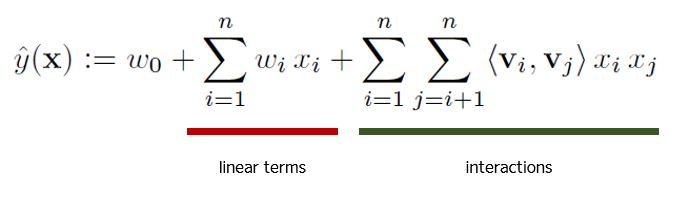

In [ ]:
from IPython.display import Image
url='https://raw.githubusercontent.com/kiakass/recommendation/main/FM_formular1.jpg'
Image(url,width = 600, height = 200)

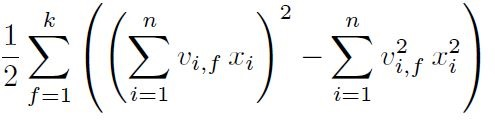

In [ ]:
url='https://raw.githubusercontent.com/kiakass/recommendation/main/FM_formular3.jpg'
Image(url,width = 500, height = 100)

In [ ]:
# Forward
def train_on_batch(model, optimizer, accuracy, inputs, targets):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(from_logits=False,
                                                   y_true=targets,
                                                   y_pred=y_pred)
    
    # loss를 모델의 파라미터로 편미분하여 gradients를 구한다.
    grads = tape.gradient(target=loss, sources=model.trainable_variables)

    # apply_gradients()를 통해 processed gradients를 적용한다.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # accuracy: update할 때마다 정확도는 누적되어 계산된다.
    accuracy.update_state(targets, y_pred)

    return loss


# 반복 학습 함수
def train(epochs):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_train, tf.float32), tf.cast(Y_train, tf.float32))).shuffle(500).batch(8)

    test_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32))).shuffle(200).batch(8)

    model = FM()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    accuracy = BinaryAccuracy(threshold=0.5)
    loss_history = []

    for i in range(epochs):
      for x, y in train_ds:
          loss = train_on_batch(model, optimizer, accuracy, x, y)
          loss_history.append(loss)

      if i % 10 == 0:
          print("step {:03d} : 누적 평균 손실 = {:.4f}".format(i, np.mean(loss_history)))
          print("step {:03d} : 누적 정확도    = {:.4f}".format(i, accuracy.result().numpy()))


    test_accuracy = BinaryAccuracy(threshold=0.5)
    for x, y in test_ds:
        y_pred = model(x)
        test_accuracy.update_state(y, y_pred)

    print("테스트 정확도: {:.4f}".format(test_accuracy.result().numpy()))

In [ ]:
train(100)

step 000 : 누적 평균 손실 = 1.0854
step 000 : 누적 정확도    = 0.4345
step 010 : 누적 평균 손실 = 0.5162
step 010 : 누적 정확도    = 0.7638
step 020 : 누적 평균 손실 = 0.3937
step 020 : 누적 정확도    = 0.8395
step 030 : 누적 평균 손실 = 0.3329
step 030 : 누적 정확도    = 0.8721
step 040 : 누적 평균 손실 = 0.2947
step 040 : 누적 정확도    = 0.8908
step 050 : 누적 평균 손실 = 0.2678
step 050 : 누적 정확도    = 0.9042
step 060 : 누적 평균 손실 = 0.2474
step 060 : 누적 정확도    = 0.9143
step 070 : 누적 평균 손실 = 0.2313
step 070 : 누적 정확도    = 0.9219
step 080 : 누적 평균 손실 = 0.2182
step 080 : 누적 정확도    = 0.9279
step 090 : 누적 평균 손실 = 0.2073
step 090 : 누적 정확도    = 0.9326
테스트 정확도: 0.9917
